In [1]:
import csv
import os
from functools import partial
import json

import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt

from gerrychain import (
   Election,
   Graph,
   MarkovChain,
   Partition,
   accept,
   constraints,
   updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom
from gerrychain.proposals import flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

newdir = "./Outputs/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")

In [2]:
import pickle

In [3]:
import numpy as np
from gerrychain import Partition
from gerrychain.grid import Grid
from wasserplan import Pair
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from gerrychain.proposals import flip
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd
import geopandas as gpd
from gerrychain.tree import recursive_tree_part
import tqdm
from random import random
from gerrychain.metrics import efficiency_gap, mean_median

from gerrychain.updaters import cut_edges
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept

In [4]:
unique_label = "GEOID10"
pop_col = "TOTPOP"
district_col = "CD"

graph_path = "./IA_counties/IA_counties.shp"

graph = Graph.from_file(graph_path, reproject = False)

graph.to_json("ia_json.json")

jgraph = Graph.from_json("ia_json.json")

df = gpd.read_file(graph_path)

In [5]:
df

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,area,perimeter,geometry
0,19,127,19127,Marshall,Marshall County,1482770678,1803086,+42.0416910,-092.9814523,40648,...,8472,335,17980,7652,9146,1182,1,1.486635e+09,154132.7276,"POLYGON ((-92.76679299999999 42.12346, -92.766..."
1,19,011,19011,Benton,Benton County,1855117342,5760770,+42.0925474,-092.0576300,26076,...,6940,221,13844,4678,8232,934,1,1.863424e+09,174235.2795,"POLYGON ((-91.947732 41.861856, -91.955139 41...."
2,19,041,19041,Clay,Clay County,1469139214,13866941,+43.0798220,-095.1497261,16667,...,4951,166,8617,2249,5877,491,4,1.484339e+09,153993.8433,"POLYGON ((-95.269263 43.255373, -95.2613959999..."
3,19,165,19165,Shelby,Shelby County,1530110414,1486135,+41.6790143,-095.3089173,12167,...,3911,103,6370,1662,4362,346,4,1.533974e+09,165668.6033,"POLYGON ((-95.209023 41.863709, -95.2089029999..."
4,19,043,19043,Clayton,Clayton County,2016405612,36586071,+42.8409979,-091.3235108,18129,...,4164,168,9129,3237,5317,575,1,2.055066e+09,204271.2115,"POLYGON ((-91.25080199999999 42.645576, -91.25..."
5,19,097,19097,Jackson,Jackson County,1647332960,35141529,+42.1642812,-090.5745965,19848,...,4177,158,10310,3837,5824,649,1,1.684704e+09,189392.0209,"POLYGON ((-90.89822599999999 42.120593, -90.89..."
6,19,079,19079,Hamilton,Hamilton County,1493777716,1965344,+42.3907681,-093.7091980,15673,...,3991,154,7694,2726,4463,505,4,1.497577e+09,161100.5455,"POLYGON ((-93.81572899999999 42.209597, -93.82..."
7,19,173,19173,Taylor,Taylor County,1377618597,7133648,+40.7379489,-094.6971082,6317,...,1683,50,3029,758,2111,160,3,1.387513e+09,150175.8387,"POLYGON ((-94.47147 40.725934, -94.47147 40.72..."
8,19,139,19139,Muscatine,Muscatine County,1133040484,30198875,+41.4837760,-091.1186992,42745,...,8168,374,19434,8368,9584,1482,2,1.165154e+09,151681.4098,"POLYGON ((-91.368521 41.423178, -91.3685199999..."
9,19,197,19197,Wright,Wright County,1503286817,4703964,+42.7330073,-093.7347352,13229,...,3349,93,6026,1896,3800,330,4,1.509593e+09,155242.0365,"POLYGON ((-93.97146499999999 42.8197, -93.9714..."


In [6]:
graph

<Graph [99 nodes, 222 edges]>

In [7]:
def num_splits(partition): # counting how many times a split is done to a county/block group because we don't want that
    df["current"] = df[unique_label].map(dict(partition.assignment))
    splits = sum(df.groupby("CD")["current"].nunique() > 1)
    return splits

def avg_pop_dist(partition):
    ideal_population = sum(partition["population"].values()) / len(
    partition
)
    total_deviation = sum([abs(v - ideal_population) for v in partition['population'].values()])
    return (total_deviation)/len(partition)

In [8]:
def pop_dist_pct(partition):
    ideal_population = ideal_population = sum(partition["population"].values()) / len(
    partition)
    total_deviation = total_deviation = sum([abs(v - ideal_population) for v in partition['population'].values()])
    avg_dist = total_deviation/len(partition)
    return avg_dist/ideal_population

In [9]:
def polsby_popper(partition):
#    print(partition["Area"])
    
    return (4*np.pi*partition["Area"])/np.square(partition["Perimeter"])

In [10]:
my_updaters = {
    "cut_edges": cut_edges,
    "population": updaters.Tally("TOTPOP", alias = "population"),
    "avg_pop_dist": avg_pop_dist,
    "pop_dist_pct" : pop_dist_pct,
    "area_land": updaters.Tally("ALAND10", alias = "area_land"),
    "area_water": updaters.Tally("AWATER10", alias = "area_water"),
    "Perimeter": updaters.Tally("perimeter", alias = "Perimeter"),
    "Area": updaters.Tally("area", alias = "Area")
}

In [11]:
num_elections = 3

election_names = [
    "PRES00",
    "PRES04",
    "PRES08",
]

election_columns = [
    ["PRES00D", "PRES00R"],
    ["PRES04D", "PRES04R"],
    ["PRES08D", "PRES08R"]
]

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

In [12]:
election_updaters = {election.name: election for election in elections}

my_updaters.update(election_updaters)

num_dist = 4

initial_partition = Partition(jgraph, "CD", my_updaters) # by typing in "CD," we are saying to put every county into the congressional district that they belong to

ideal_population = ideal_population = sum(initial_partition["population"].values()) / len(
    initial_partition
)

#proposal = partial(
#    flip, pop_col="TOTPOP", pop_target=ideal_population, epsilon=0.02, node_repeats=2
#)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

In [13]:
chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=[single_flip_contiguous],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=200
)

In [69]:
#chain = MarkovChain(
#    proposal=proposal,
#    constraints=[
#        constraints.within_percent_of_ideal_population(initial_partition, 0.02),
#        compactness_bound,  # single_flip_contiguous#no_more_discontiguous
#    ],
#    accept=accept.always_accept,
#    initial_state=initial_partition,
#    total_steps=200
#)

In [14]:
partitions=[] # recording partitions at each step
for part in chain:
    partitions += [part]

In [15]:
len(partitions)

200

In [16]:
len(partitions)

200

In [17]:
import wasserplan

In [83]:
wasserplan.Pair(partitions[0], partitions[1]).distance

0.24971081617977747

In [19]:
distances=np.zeros((200,200))
for i in range(200):
    for j in range(i+1,200):
        distances[i][j] = wasserplan.Pair(partitions[i],partitions[j]).distance
        distances[j][i] = distances[i][j]

In [85]:
distances

array([[0.        , 0.24971082, 0.07564103, ..., 8.15378417, 7.98433867,
        7.87984131],
       [0.24971082, 0.        , 0.2644785 , ..., 8.18539203, 8.01189795,
        7.9074006 ],
       [0.07564103, 0.2644785 , 0.        , ..., 8.07814314, 7.90869764,
        7.80420029],
       ...,
       [8.15378417, 8.18539203, 8.07814314, ..., 0.        , 0.29387885,
        0.4856778 ],
       [7.98433867, 8.01189795, 7.90869764, ..., 0.29387885, 0.        ,
        0.28968254],
       [7.87984131, 7.9074006 , 7.80420029, ..., 0.4856778 , 0.28968254,
        0.        ]])

## MDS

In [21]:
from sklearn.manifold import MDS

In [22]:
mds = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity='euclidean')

In [23]:
pos1=mds.fit(distances).embedding_

/anaconda3/envs/VRDI/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


In [24]:
import matplotlib.pyplot as plt

In [25]:
X_MDS_1=[]
Y_MDS_1=[]
for i in range(200):
    X_MDS_1.append(pos1[i][0])
    Y_MDS_1.append(pos1[i][1])

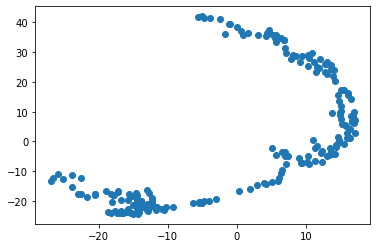

In [26]:
plt.scatter(X_MDS_1,Y_MDS_1)

In [27]:
np.save("flip_run1.npy",distances)

In [66]:
partitions

[<Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 p

# t-SNE

In [28]:
import sklearn
X_embedded=sklearn.manifold.TSNE(n_components=2).fit_transform(distances)

In [29]:
X_embedded

array([[ -9.148426  , -18.325893  ],
       [ -9.422259  , -18.213589  ],
       [ -9.0062275 , -18.313633  ],
       [ -9.401025  , -17.910343  ],
       [ -9.316127  , -17.647272  ],
       [ -8.619791  , -17.86345   ],
       [ -8.336978  , -17.913881  ],
       [ -9.048197  , -17.43488   ],
       [ -8.75442   , -17.328985  ],
       [ -8.633608  , -17.147915  ],
       [ -8.04239   , -17.442049  ],
       [ -8.122544  , -17.231667  ],
       [ -7.74584   , -17.029089  ],
       [ -7.5902715 , -16.758179  ],
       [ -8.189116  , -16.420141  ],
       [ -7.9246616 , -16.28519   ],
       [ -8.377118  , -16.39978   ],
       [ -7.8769913 , -16.653954  ],
       [ -7.353516  , -16.328402  ],
       [ -7.27866   , -16.008581  ],
       [ -7.7556376 , -15.874054  ],
       [ -8.066858  , -15.808322  ],
       [ -7.362132  , -15.545253  ],
       [ -7.452897  , -15.391501  ],
       [ -6.8112073 , -14.875867  ],
       [ -6.4963956 , -14.561337  ],
       [ -5.797147  , -14.221726  ],
 

In [30]:
X_tSNE_1=[]
Y_tSNE_1=[]
for i in range(200):
    X_tSNE_1.append(X_embedded[i][0])
    Y_tSNE_1.append(X_embedded[i][1])

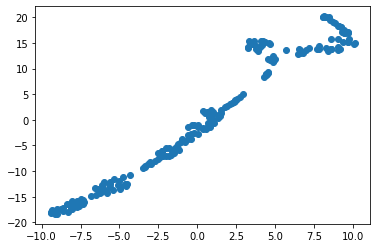

In [31]:
plt.scatter(X_tSNE_1,Y_tSNE_1)

In [32]:
partitions

[<Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 parts]>,
 <Partition [4 p

In [33]:
type(partitions)

list

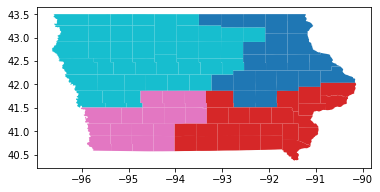

In [63]:
partitions[0].plot(df)

## SMACOF

In [34]:
import sklearn
smacof=sklearn.manifold.mds.smacof(distances, metric=True, n_components=2, init=None, n_init=8, n_jobs=None, max_iter=300, verbose=0, eps=0.001, random_state=None, return_n_iter=False)

In [35]:
X_SMACOF_1=[t[0] for t in smacof[0]]
Y_SMACOF_1=[t[1] for t in smacof[0]]

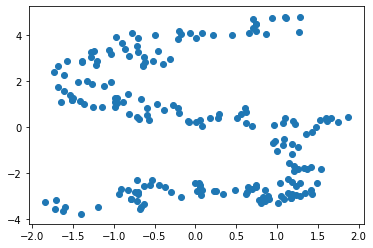

In [36]:
plt.scatter(X_SMACOF_1,Y_SMACOF_1)

# 20,000 steps and recording every 100 steps

In [37]:
chain2 = MarkovChain(
    proposal=propose_random_flip,
    constraints=[single_flip_contiguous],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=20000
)

In [38]:
partitions2=[]
t=0
for part in chain2:
    t += 1
    if t % 100 == 0:
        partitions2 += [part]

In [39]:
len(partitions2)

200

In [40]:
distances2=np.zeros((200,200))
for i in range(200):
    for j in range(i+1,200):
        distances2[i][j] = wasserplan.Pair(partitions2[i],partitions2[j]).distance
        distances2[j][i] = distances2[i][j]

## MDS

In [41]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity='euclidean')

pos2=mds.fit(distances2).embedding_

import matplotlib.pyplot as plt

X_MDS_2=[]
Y_MDS_2=[]
for i in range(200):
    X_MDS_2.append(pos2[i][0])
    Y_MDS_2.append(pos2[i][1])

/anaconda3/envs/VRDI/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


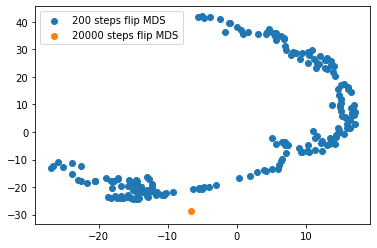

In [94]:
plt.scatter(X_MDS_1,Y_MDS_1)
plt.scatter(X_MDS_2[0:1],Y_MDS_2[0:1])
plt.legend(('200 steps flip MDS','20000 steps flip MDS'), loc='upper left')
#plt.show()

## t-SNE

In [43]:
import sklearn
X_embedded=sklearn.manifold.TSNE(n_components=2).fit_transform(distances2)

X_tSNE_2=[]
Y_tSNE_2=[]
for i in range(200):
    X_tSNE_2.append(X_embedded[i][0])
    Y_tSNE_2.append(X_embedded[i][1])

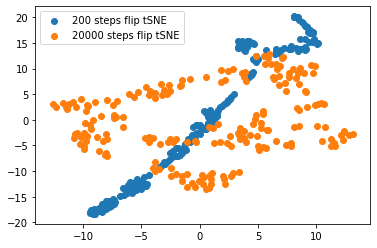

In [44]:
plt.scatter(X_tSNE_1,Y_tSNE_1)
plt.scatter(X_tSNE_2,Y_tSNE_2)
plt.legend(('200 steps flip tSNE','20000 steps flip tSNE'), loc='upper left')

## SMACOF

In [45]:
import sklearn
smacof=sklearn.manifold.mds.smacof(distances2, metric=True, n_components=2, init=None, n_init=8, n_jobs=None, max_iter=300, verbose=0, eps=0.001, random_state=None, return_n_iter=False)

X_SMACOF_2=[t[0] for t in smacof[0]]
Y_SMACOF_2=[t[1] for t in smacof[0]]

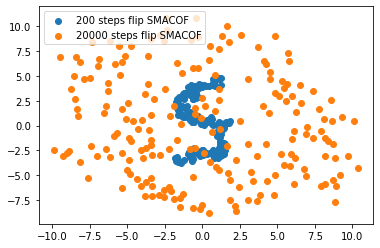

In [46]:
plt.scatter(X_SMACOF_1,Y_SMACOF_1)
plt.scatter(X_SMACOF_2,Y_SMACOF_2)
plt.legend(('200 steps flip SMACOF','20000 steps flip SMACOF'), loc='upper left')

In [47]:
np.save("flip_run2_20000_steps.npy",distances2)

# 20,000 steps and recording every 100 steps BUT starting at step 50

In [49]:
chain3 = MarkovChain(
    proposal=propose_random_flip,
    constraints=[single_flip_contiguous],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=20000
)

In [54]:
partitions3=[]
t=50
for part in chain3:
    t += 1
    #print(t)
    if t % 100 == 0:
        #print(t)
        partitions3 += [part]

In [55]:
distances3=np.zeros((200,200))
for i in range(200):
    for j in range(i+1,200):
        distances3[i][j] = wasserplan.Pair(partitions3[i],partitions3[j]).distance
        distances3[j][i] = distances3[i][j]

In [56]:
distances3

array([[ 0.        ,  2.85934373,  3.35088186, ..., 10.40990675,
        10.5037744 ,  8.60528191],
       [ 2.85934373,  0.        ,  2.96995197, ...,  9.53372989,
         9.9291162 , 10.55426346],
       [ 3.35088186,  2.96995197,  0.        , ..., 10.11945399,
        10.36719097,  9.47809348],
       ...,
       [10.40990675,  9.53372989, 10.11945399, ...,  0.        ,
         2.69699896,  5.33888256],
       [10.5037744 ,  9.9291162 , 10.36719097, ...,  2.69699896,
         0.        ,  5.14406846],
       [ 8.60528191, 10.55426346,  9.47809348, ...,  5.33888256,
         5.14406846,  0.        ]])

# 50000 steps

In [57]:
chain4 = MarkovChain(
    proposal=propose_random_flip,
    constraints=[single_flip_contiguous],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=50000
)

In [58]:
partitions4=[]
t=0
for part in chain4:
    t += 1
    #print(t)
    if t % 100 == 0:
        #print(t)
        partitions4 += [part]

In [60]:
distances4=np.zeros((500,500))
for i in range(500):
    for j in range(i+1,500):
        distances4[i][j] = wasserplan.Pair(partitions4[i],partitions4[j]).distance
        distances4[j][i] = distances4[i][j]

In [62]:
len(distances4)

500

## Doing embedding ONLY ONCE on both 200 steps and 20000 steps flip

In [95]:
new_partitions=partitions[0:100]+partitions2[0:100]

In [96]:
Distance_matrix=np.zeros((200,200))

for i in range(200):
    for j in range(i+1,200):
        Distance_matrix[i][j] = wasserplan.Pair(new_partitions[i],new_partitions[j]).distance
        Distance_matrix[j][i] = Distance_matrix[i][j]

In [97]:
Distance_matrix

array([[0.        , 0.24971082, 0.07564103, ..., 9.4825896 , 8.65101241,
        8.57248078],
       [0.24971082, 0.        , 0.2644785 , ..., 9.35503031, 8.51261835,
        8.48710388],
       [0.07564103, 0.2644785 , 0.        , ..., 9.48525765, 8.65443122,
        8.54812181],
       ...,
       [9.4825896 , 9.35503031, 9.48525765, ..., 0.        , 2.91664879,
        4.07992176],
       [8.65101241, 8.51261835, 8.65443122, ..., 2.91664879, 0.        ,
        3.65575946],
       [8.57248078, 8.48710388, 8.54812181, ..., 4.07992176, 3.65575946,
        0.        ]])

In [98]:
np.save("flip_run1_2_combined.npy",Distance_matrix)

In [99]:
import sklearn
smacof=sklearn.manifold.mds.smacof(Distance_matrix, metric=True, n_components=2, init=None, n_init=8, n_jobs=None, max_iter=300, verbose=0, eps=0.001, random_state=None, return_n_iter=False)

X_SMACOF_combined=[t[0] for t in smacof[0]]
Y_SMACOF_combined=[t[1] for t in smacof[0]]

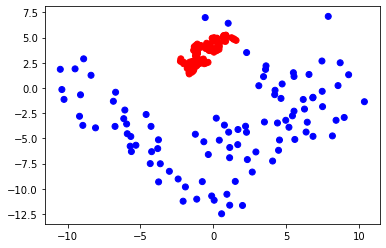

In [100]:
plt.scatter(X_SMACOF_combined,Y_SMACOF_combined, color=['red']*100 + ['blue']*100)